In [1]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

from data_builder import *
from utils import *
import torch
import numpy as np
import matplotlib.pyplot as plt

# %%

num_trajectories = 100
n_test_traj = 2
num_nodes = 2
T_max = 10.1
T_max_t = 10.1
dt = 0.1
srate = 0.1
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 0)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)
print(train_data['x'].shape)
tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)
print(tnow.shape)

traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
train_dataloader = DataLoader(traindat, batch_size=1500, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=1500, num_workers=2, shuffle=False)

data_dict = {'train': train_dataloader, 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}

torch.pi = torch.tensor(np.pi)


def train_model(model, optimizer,lr_sched, num_epochs=1, energy_term=False, integrator_embedded=False, reg_grad=False):
    for epoch in range(num_epochs):
        print('epoch:{}'.format(epoch))

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                # scheduler.step()
                model.train()
            else:
                model.eval()
            lr_sched.step()
            running_loss = 0.0
            # Iterate over data.
            for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict[phase]):
                if phase == 'train':
                    optimizer.zero_grad()
                q, q_next, qdx = q.float(), q_next.float(), qdx.float()
                q.to(device)
                q_next.to(device)
                energy_.to(device)
                qdx.to(device)
                tevals = tevals.float()
                tevals.to(device)
                loss = 0
                q.requires_grad = True
                tevals.requires_grad = True

                if integrator_embedded:
                    next_step_pred = model.next_step(q,tevals)
                    state_loss = torch.mean((next_step_pred - q_next) ** 2)
                else:
                    next_step_pred = model.time_deriv(q,tevals)
                    state_loss = torch.mean((next_step_pred - qdx) ** 2)

                loss = state_loss
                print(f'{phase} state loss {state_loss}')

                beta = 1e-5

                if energy_term:
                    f1 = model.get_H(torch.cat([q,tevals.reshape(-1,1)],1))
                    energy_loss = ((f1 - energy_) ** 2).mean()
                    print(f'{phase} energy loss {energy_loss}')
                    loss += beta*energy_loss

                lambda_ = 1

                if reg_grad:
                    dhdt,dfdq,dfdp = model.time_deriv2(q, tevals)
                    c1 = torch.mean(torch.square(dhdt))
                    c2 = torch.mean(torch.square(dfdq))
                    c3 = torch.mean(torch.square(dfdp))
                    loss += c1 + c2 + c3

                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                running_loss += state_loss

            loss_collater[phase].append(running_loss)
            epoch_loss = running_loss
            print('{} Loss: {:.10f}'.format(phase, epoch_loss))

    plt.figure()
    plt.plot(loss_collater['train'], label='train')
    plt.plot(loss_collater['valid'], label='valid')
    plt.yscale('log')
    plt.title(f'simple pendulum: ntrain_inits:{num_trajectories},ntest_inits:{n_test_traj},tmax:{T_max},dt:{dt}')
    plt.legend()
    plt.show()
    #
    #
    #
    # preds = []
    # pred_ham = []
    # qinit = q[0].reshape(1, -1)
    # for i in range(len(q_next)):
    #     next_step_pred = model.next_step(qinit,tevals[i])
    #     pred_ham.append(model.get_H(torch.cat([qinit,tevals[i].reshape(-1,1)],1)))
    #     preds.append(next_step_pred)
    #     qinit = next_step_pred
    #
    # # pred_ham = torch.cat(pred_ham)
    #
    # # plt.figure()
    # # plt.scatter(range(len(q_next)),pred_ham.detach().numpy())
    # # plt.show()
    #
    # preds = torch.cat(preds)
    # preds = preds.detach().numpy()
    # q_next = q_next.detach().numpy()
    #
    # plt.figure()
    # plt.scatter(range(len(preds)),np.mean(np.abs(preds-q_next),1))
    # plt.show()
    #
    #
    # print(np.mean((preds-q_next)**2))
    # plt.figure()
    # plt.plot(preds[:, 0], preds[:, 1], label='predicted')
    # plt.plot(q_next[:, 0], q_next[:, 1], label='true')
    # plt.scatter(preds[:, 0], preds[:, 1], label='predicted', s=3)
    # plt.scatter(q_next[:, 0], q_next[:, 1], label='true', s=3)
    # plt.legend()
    # plt.show()
    return model
# model_ft = HNN(2, 200, 1, 0.01)


cpu
(10100, 2)
(10000, 2)


epoch:0


/Users/shaan/anaconda3/envs/main/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train state loss 0.008809384889900684
train state loss 0.00883367471396923
train state loss 0.008631969802081585
train state loss 0.007935691624879837
train state loss 0.008015389554202557
train state loss 0.006888239644467831
train state loss 0.005590884014964104
train Loss: 0.0547052398
valid state loss 0.005726882256567478
valid Loss: 0.0057268823
epoch:1
train state loss 0.00570104643702507
train state loss 0.008427421562373638
train state loss 0.00584997097030282
train state loss 0.006184865720570087
train state loss 0.004690177738666534
train state loss 0.004650970920920372
train state loss 0.0034751540515571833
train Loss: 0.0389796086
valid state loss 0.003153433557599783
valid Loss: 0.0031534336
epoch:2
train state loss 0.0030986592173576355
train state loss 0.0030540935695171356
train state loss 0.003060016082599759
train state loss 0.00323272030800581
train state loss 0.0027265329845249653
train state loss 0.002863676752895117
train state loss 0.002843038411810994
train Loss

train state loss 0.0018681982764974236
train Loss: 0.0128394086
valid state loss 0.0016994684701785445
valid Loss: 0.0016994685
epoch:23
train state loss 0.0017586089670658112
train state loss 0.0019079886842519045
train state loss 0.0017733694985508919
train state loss 0.0018622924108058214
train state loss 0.0017782592913135886
train state loss 0.0018749140435829759
train state loss 0.0019004492787644267
train Loss: 0.0128558818
valid state loss 0.0016738490667194128
valid Loss: 0.0016738491
epoch:24
train state loss 0.001706860726699233
train state loss 0.001778455451130867
train state loss 0.0017166374018415809
train state loss 0.0017528054304420948
train state loss 0.0018052557716146111
train state loss 0.0017047455767169595
train state loss 0.0017426484264433384
train Loss: 0.0122074094
valid state loss 0.0015896118711680174
valid Loss: 0.0015896119
epoch:25
train state loss 0.0018399541731923819
train state loss 0.0015832242788746953
train state loss 0.001705415896140039
train s

valid state loss 0.0002372549060964957
valid Loss: 0.0002372549
epoch:45
train state loss 0.0002291692071594298
train state loss 0.00022106023970991373
train state loss 0.00015904010797385126
train state loss 0.00020147865870967507
train state loss 0.0002063697756966576
train state loss 0.00016693188808858395
train state loss 0.00017760528135113418
train Loss: 0.0013616552
valid state loss 0.00017449347069486976
valid Loss: 0.0001744935
epoch:46
train state loss 0.00015313795302063227
train state loss 0.00015740195522084832
train state loss 0.00019528194388840348
train state loss 0.00018342482508160174
train state loss 0.0001678119442658499
train state loss 0.00016070222773123533
train state loss 0.0001408960815751925
train Loss: 0.0011586569
valid state loss 0.00015843598521314561
valid Loss: 0.0001584360
epoch:47
train state loss 0.00014684407506138086
train state loss 0.00011958902177866548
train state loss 0.0001333559484919533
train state loss 0.00013814389239996672
train state lo

valid state loss 5.884337588213384e-05
valid Loss: 0.0000588434
epoch:67
train state loss 6.0935453802812845e-05
train state loss 5.082246570964344e-05
train state loss 6.549505633302033e-05
train state loss 9.148407116299495e-05
train state loss 0.00012176056043244898
train state loss 8.961457206169143e-05
train state loss 5.382297240430489e-05
train Loss: 0.0005339351
valid state loss 3.578682662919164e-05
valid Loss: 0.0000357868
epoch:68
train state loss 4.1016020986717194e-05
train state loss 5.9645237342920154e-05
train state loss 0.00012023480667266995
train state loss 0.000189523896551691
train state loss 0.00018331686442252249
train state loss 0.00010736009426182136
train state loss 4.489987622946501e-05
train Loss: 0.0007459968
valid state loss 9.337812662124634e-05
valid Loss: 0.0000933781
epoch:69
train state loss 9.368034079670906e-05
train state loss 0.00015904860629234463
train state loss 0.00011492922203615308
train state loss 4.6619617933174595e-05
train state loss 6.2

valid state loss 5.656143184751272e-05
valid Loss: 0.0000565614
epoch:89
train state loss 5.377261186367832e-05
train state loss 6.332472548820078e-05
train state loss 5.151213190401904e-05
train state loss 2.9440194339258596e-05
train state loss 2.486834637238644e-05
train state loss 2.6120305847143754e-05
train state loss 2.843575202859938e-05
train Loss: 0.0002774741
valid state loss 2.566478906373959e-05
valid Loss: 0.0000256648
epoch:90
train state loss 2.6787762180902064e-05
train state loss 2.101548670907505e-05
train state loss 2.2449050447903574e-05
train state loss 2.9078608349664137e-05
train state loss 3.54697804141324e-05
train state loss 3.2431249564979225e-05
train state loss 2.4283939637825824e-05
train Loss: 0.0001915159
valid state loss 1.6577652786509134e-05
valid Loss: 0.0000165777
epoch:91
train state loss 1.7165713870781474e-05
train state loss 1.2267031706869602e-05
train state loss 1.7864842448034324e-05
train state loss 2.8123173251515254e-05
train state loss 3

valid state loss 6.711633614031598e-05
valid Loss: 0.0000671163
epoch:111
train state loss 6.493770342785865e-05
train state loss 3.721417306223884e-05
train state loss 1.7214244508068077e-05
train state loss 3.692265454446897e-05
train state loss 5.474108911585063e-05
train state loss 5.3842832130612805e-05
train state loss 4.611691110767424e-05
train Loss: 0.0003109896
valid state loss 2.9667653507203795e-05
valid Loss: 0.0000296677
epoch:112
train state loss 2.6685571356210858e-05
train state loss 1.836897172324825e-05
train state loss 2.131816654582508e-05
train state loss 3.4704760764725506e-05
train state loss 3.2879397622309625e-05
train state loss 2.603352550067939e-05
train state loss 2.0228346329531632e-05
train Loss: 0.0001802187
valid state loss 2.107061845890712e-05
valid Loss: 0.0000210706
epoch:113
train state loss 2.0600469724740833e-05
train state loss 1.235868694493547e-05
train state loss 1.3798069630865939e-05
train state loss 2.4421671696472913e-05
train state loss

valid state loss 2.469385208314634e-06
valid Loss: 0.0000024694
epoch:133
train state loss 2.6841225917451084e-06
train state loss 2.5075278244912624e-06
train state loss 2.5617766823415877e-06
train state loss 2.6808986604009988e-06
train state loss 2.439772970319609e-06
train state loss 2.8842355277447496e-06
train state loss 2.3918166789371753e-06
train Loss: 0.0000181502
valid state loss 2.429269443382509e-06
valid Loss: 0.0000024293
epoch:134
train state loss 2.359226755288546e-06
train state loss 2.85797568722046e-06
train state loss 2.486498487996869e-06
train state loss 2.442021923343418e-06
train state loss 2.512323590053711e-06
train state loss 2.6386169338366017e-06
train state loss 2.4835312615323346e-06
train Loss: 0.0000177802
valid state loss 2.4429239147139015e-06
valid Loss: 0.0000024429
epoch:135
train state loss 2.441340029690764e-06
train state loss 2.473854465279146e-06
train state loss 2.5448832730035065e-06
train state loss 2.521712303860113e-06
train state loss 

valid state loss 1.7953730093722697e-06
valid Loss: 0.0000017954
epoch:155
train state loss 1.891028887257562e-06
train state loss 2.0305926682340214e-06
train state loss 1.95357165466703e-06
train state loss 2.121197894666693e-06
train state loss 2.079583964587073e-06
train state loss 1.9828360109386267e-06
train state loss 1.8931084468931658e-06
train Loss: 0.0000139519
valid state loss 1.8082154156218166e-06
valid Loss: 0.0000018082
epoch:156
train state loss 2.00186445908912e-06
train state loss 1.909855200210586e-06
train state loss 1.8753790982373175e-06
train state loss 2.0589861833286704e-06
train state loss 1.99983310267271e-06
train state loss 1.8686677094592596e-06
train state loss 2.192226929764729e-06
train Loss: 0.0000139068
valid state loss 1.7579044424564927e-06
valid Loss: 0.0000017579
epoch:157
train state loss 1.9208482626709156e-06
train state loss 2.1185396690270863e-06
train state loss 1.843761197051208e-06
train state loss 1.998147354242974e-06
train state loss 1

train state loss 1.6760403696025605e-06
train state loss 1.7481193026469555e-06
train Loss: 0.0000121847
valid state loss 1.5722387161076767e-06
valid Loss: 0.0000015722
epoch:177
train state loss 1.7399723901689867e-06
train state loss 1.7439729163015727e-06
train state loss 1.695134073997906e-06
train state loss 1.666987600401626e-06
train state loss 1.6920262169151101e-06
train state loss 1.6400207414335455e-06
train state loss 1.7821865867517772e-06
train Loss: 0.0000119603
valid state loss 1.471356995352835e-06
valid Loss: 0.0000014714
epoch:178
train state loss 1.7215755860888748e-06
train state loss 1.6722715372452512e-06
train state loss 1.8148176650356618e-06
train state loss 1.5230017424983089e-06
train state loss 1.8159219052904518e-06
train state loss 1.6855124158610124e-06
train state loss 1.590730107636773e-06
train Loss: 0.0000118238
valid state loss 1.5233443946272018e-06
valid Loss: 0.0000015233
epoch:179
train state loss 1.947022155945888e-06
train state loss 1.617287

train state loss 1.5386234508696361e-06
train state loss 1.4501254099741345e-06
train state loss 1.443574774384615e-06
train state loss 1.5040358221085626e-06
train state loss 1.4789331999054411e-06
train Loss: 0.0000104895
valid state loss 1.3224306485426496e-06
valid Loss: 0.0000013224
epoch:199
train state loss 1.532750957267126e-06
train state loss 1.5312565437852754e-06
train state loss 1.5535143802480889e-06
train state loss 1.4076175602895091e-06
train state loss 1.4406067521122168e-06
train state loss 1.4748227386007784e-06
train state loss 1.4383475672730128e-06
train Loss: 0.0000103789
valid state loss 1.3375268963500275e-06
valid Loss: 0.0000013375


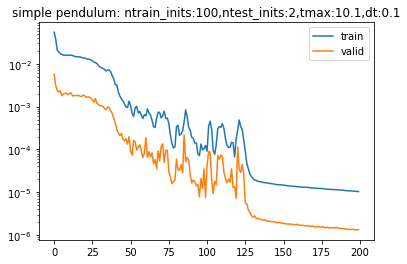

In [2]:
from model import HNN as HNN1
model_ft = HNN1(3, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model1 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)


epoch:0
train state loss 0.008365258574485779
train state loss 0.3016255795955658
train state loss 0.053212907165288925
train state loss 0.0206630676984787
train state loss 0.012148690409958363
train state loss 0.0251879021525383
train state loss 0.019548632204532623
train Loss: 0.4407519996
valid state loss 0.011981308460235596
valid Loss: 0.0119813085
epoch:1
train state loss 0.011065508238971233
train state loss 0.008153234608471394
train state loss 0.009799369610846043
train state loss 0.010777682065963745
train state loss 0.011533823795616627
train state loss 0.010518832132220268
train state loss 0.009233391843736172
train Loss: 0.0710818395
valid state loss 0.009365088306367397
valid Loss: 0.0093650883
epoch:2
train state loss 0.008563976734876633
train state loss 0.009201127104461193
train state loss 0.009811261668801308
train state loss 0.009873817674815655
train state loss 0.009506645612418652
train state loss 0.00887430738657713
train state loss 0.008379535749554634
train Los

train state loss 0.0014951443299651146
train state loss 0.0013852696865797043
train state loss 0.001418500323779881
train Loss: 0.0101344725
valid state loss 0.0011977864196524024
valid Loss: 0.0011977864
epoch:23
train state loss 0.0014294786378741264
train state loss 0.0015229047276079655
train state loss 0.001457176636904478
train state loss 0.0015534732956439257
train state loss 0.0012893162202090025
train state loss 0.0014485983410850167
train state loss 0.001363335526548326
train Loss: 0.0100642834
valid state loss 0.0013737152330577374
valid Loss: 0.0013737152
epoch:24
train state loss 0.0014488889137282968
train state loss 0.0014375861501321197
train state loss 0.001387408934533596
train state loss 0.0014334520092234015
train state loss 0.0014499826356768608
train state loss 0.0014489167369902134
train state loss 0.0013752051163464785
train Loss: 0.0099814404
valid state loss 0.0012693925527855754
valid Loss: 0.0012693926
epoch:25
train state loss 0.0014255914138630033
train st

train Loss: 0.0074298126
valid state loss 0.0008977139950729907
valid Loss: 0.0008977140
epoch:45
train state loss 0.0009507242939434946
train state loss 0.0011224700137972832
train state loss 0.001056245295330882
train state loss 0.00112875085324049
train state loss 0.0011899189557880163
train state loss 0.0010931746801361442
train state loss 0.0009663525852374732
train Loss: 0.0075076367
valid state loss 0.0010105425026267767
valid Loss: 0.0010105425
epoch:46
train state loss 0.0010095247998833656
train state loss 0.000995673704892397
train state loss 0.0010279385605826974
train state loss 0.0010366275673732162
train state loss 0.001069586374796927
train state loss 0.0010393448173999786
train state loss 0.0011378100607544184
train Loss: 0.0073165055
valid state loss 0.0009045941988006234
valid Loss: 0.0009045942
epoch:47
train state loss 0.001059804460965097
train state loss 0.0009839610429480672
train state loss 0.001031392370350659
train state loss 0.0010273915249854326
train state

train state loss 0.0006778401439078152
train state loss 0.00045897209201939404
train state loss 0.0004521803348325193
train state loss 0.000538577267434448
train state loss 0.0004175769572611898
train state loss 0.0003683083923533559
train state loss 0.0003828081244137138
train Loss: 0.0032962631
valid state loss 0.0003984851355198771
valid Loss: 0.0003984851
epoch:68
train state loss 0.00036680925404652953
train state loss 0.00035382306668907404
train state loss 0.0003930301172658801
train state loss 0.0003802432620432228
train state loss 0.00032090782769955695
train state loss 0.00036472405190579593
train state loss 0.00037981345667503774
train Loss: 0.0025593510
valid state loss 0.00032363124773837626
valid Loss: 0.0003236312
epoch:69
train state loss 0.00035250576911494136
train state loss 0.00036558910505846143
train state loss 0.00031709298491477966
train state loss 0.0003877919225487858
train state loss 0.0005246070795692503
train state loss 0.0006924622575752437
train state los

train state loss 0.00021290453150868416
train state loss 0.0005906700971536338
train state loss 0.00021329664741642773
train state loss 0.0002709742693696171
train state loss 0.000357926357537508
train state loss 0.0001718894491204992
train state loss 0.00019656117365229875
train Loss: 0.0020142226
valid state loss 0.0003664492687676102
valid Loss: 0.0003664493
epoch:90
train state loss 0.0003595868474803865
train state loss 0.00016544360551051795
train state loss 0.00018874782836064696
train state loss 0.00037386504118330777
train state loss 0.00015855618403293192
train state loss 0.00020807127293664962
train state loss 0.00035577008384279907
train Loss: 0.0018100409
valid state loss 0.0001379583845846355
valid Loss: 0.0001379584
epoch:91
train state loss 0.0001669043704168871
train state loss 0.0001367232034681365
train state loss 0.0001912867883220315
train state loss 0.00011536519014043733
train state loss 0.00013819077867083251
train state loss 0.00019243605493102223
train state l

train state loss 4.098356657777913e-05
train state loss 5.133444210514426e-05
train state loss 6.240732182050124e-05
train state loss 5.586355473496951e-05
train state loss 5.677333319908939e-05
train state loss 5.089196565677412e-05
train state loss 4.171984619461e-05
train Loss: 0.0003599740
valid state loss 4.989555964129977e-05
valid Loss: 0.0000498956
epoch:112
train state loss 4.523452298599295e-05
train state loss 3.588072650018148e-05
train state loss 4.4145650463178754e-05
train state loss 3.743250999832526e-05
train state loss 3.94179041904863e-05
train state loss 4.0076742152450606e-05
train state loss 4.845685907639563e-05
train Loss: 0.0002906449
valid state loss 4.4791126128984615e-05
valid Loss: 0.0000447911
epoch:113
train state loss 4.576064020511694e-05
train state loss 3.4341675927862525e-05
train state loss 3.521752296364866e-05
train state loss 4.679831909015775e-05
train state loss 5.2752635383512825e-05
train state loss 5.688953388016671e-05
train state loss 7.38

train state loss 1.980053639272228e-05
train state loss 2.019409294007346e-05
train state loss 2.0628438505809754e-05
train state loss 2.207893703598529e-05
train state loss 2.360297912673559e-05
train state loss 1.9071314454777166e-05
train state loss 2.114228846039623e-05
train Loss: 0.0001465186
valid state loss 1.7067774024326354e-05
valid Loss: 0.0000170678
epoch:134
train state loss 1.9167813661624677e-05
train state loss 2.0549776309053414e-05
train state loss 2.0180681531201117e-05
train state loss 2.1658272089553066e-05
train state loss 2.234891326224897e-05
train state loss 1.9004522982868366e-05
train state loss 2.32119309657719e-05
train Loss: 0.0001461219
valid state loss 1.718765270197764e-05
valid Loss: 0.0000171877
epoch:135
train state loss 1.9048362446483225e-05
train state loss 2.408375257800799e-05
train state loss 2.0167522961855866e-05
train state loss 2.037244485109113e-05
train state loss 2.067829336738214e-05
train state loss 1.9011926269740798e-05
train state 

valid state loss 1.4137781363388058e-05
valid Loss: 0.0000141378
epoch:155
train state loss 1.6951611542026512e-05
train state loss 1.92840689123841e-05
train state loss 1.9135966795147397e-05
train state loss 1.7096173905883916e-05
train state loss 1.971288293134421e-05
train state loss 1.4949663636798505e-05
train state loss 1.8467355403117836e-05
train Loss: 0.0001255977
valid state loss 1.4229162843548693e-05
valid Loss: 0.0000142292
epoch:156
train state loss 1.9825634808512405e-05
train state loss 1.667695505602751e-05
train state loss 1.924751813930925e-05
train state loss 1.5283760149031878e-05
train state loss 2.1152587578399107e-05
train state loss 1.6699985280865803e-05
train state loss 1.5809466276550665e-05
train Loss: 0.0001246959
valid state loss 1.409554261044832e-05
valid Loss: 0.0000140955
epoch:157
train state loss 1.917774170578923e-05
train state loss 1.7087570086005144e-05
train state loss 1.605825309525244e-05
train state loss 1.7814030798035674e-05
train state l

train state loss 1.5165311197051778e-05
train state loss 1.5076127056090627e-05
train Loss: 0.0001092566
valid state loss 1.1924181308131665e-05
valid Loss: 0.0000119242
epoch:177
train state loss 1.3597551514976658e-05
train state loss 1.7470358216087334e-05
train state loss 1.647737190069165e-05
train state loss 1.7413303794455715e-05
train state loss 1.4163277228362858e-05
train state loss 1.452778815291822e-05
train state loss 1.5047222404973581e-05
train Loss: 0.0001086969
valid state loss 1.1786634786403738e-05
valid Loss: 0.0000117866
epoch:178
train state loss 1.4357222426042426e-05
train state loss 1.508327477495186e-05
train state loss 1.6753136151237413e-05
train state loss 1.3106588085065596e-05
train state loss 1.5084838196344208e-05
train state loss 1.7049438611138612e-05
train state loss 1.7337792087346315e-05
train Loss: 0.0001087723
valid state loss 1.175423039967427e-05
valid Loss: 0.0000117542
epoch:179
train state loss 1.3447325727611315e-05
train state loss 1.86759

train state loss 1.3029101864958648e-05
train state loss 1.3139682778273709e-05
train state loss 1.3493946426024195e-05
train state loss 1.3552123164117802e-05
train state loss 1.349757076241076e-05
train Loss: 0.0000944723
valid state loss 9.975446118914988e-06
valid Loss: 0.0000099754
epoch:199
train state loss 1.49608958963654e-05
train state loss 1.3764050891040824e-05
train state loss 1.1402393283788115e-05
train state loss 1.4173729141475633e-05
train state loss 1.3512117220670916e-05
train state loss 1.2372507626423612e-05
train state loss 1.3711053725273814e-05
train Loss: 0.0000938967
valid state loss 1.0114742508449126e-05
valid Loss: 0.0000101147


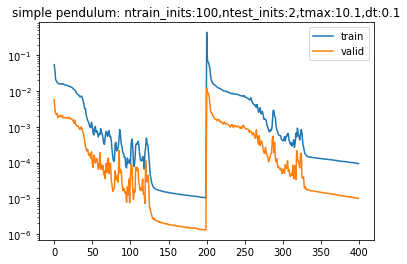

In [3]:
from model_type_I import HNN as HNN2
model_ft = HNN2(3, 200, 2, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model2 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)


epoch:0
train state loss 0.008664671331644058
train state loss 0.14462576806545258
train state loss 0.01073580700904131
train state loss 0.06448867917060852
train state loss 0.015185914002358913
train state loss 0.008832105435431004
train state loss 0.013496065512299538
train Loss: 0.2660290003
valid state loss 0.01789478212594986
valid Loss: 0.0178947821
epoch:1
train state loss 0.0174014400690794
train state loss 0.016668245196342468
train state loss 0.013359359465539455
train state loss 0.009622380137443542
train state loss 0.00870001781731844
train state loss 0.009283674880862236
train state loss 0.010192887857556343
train Loss: 0.0852280110
valid state loss 0.011925382539629936
valid Loss: 0.0119253825
epoch:2
train state loss 0.011416932567954063
train state loss 0.011284556239843369
train state loss 0.010304389521479607
train state loss 0.009243270382285118
train state loss 0.008889812044799328
train state loss 0.008683600462973118
train state loss 0.009201491251587868
train Los

train state loss 0.0022731972858309746
train Loss: 0.0166013204
valid state loss 0.0026222635060548782
valid Loss: 0.0026222635
epoch:23
train state loss 0.002508857985958457
train state loss 0.002368638291954994
train state loss 0.0024345286656171083
train state loss 0.002378751989454031
train state loss 0.0025753190275281668
train state loss 0.0025142196100205183
train state loss 0.0024335121270269156
train Loss: 0.0172138270
valid state loss 0.0024592820554971695
valid Loss: 0.0024592821
epoch:24
train state loss 0.002496124478057027
train state loss 0.002567180898040533
train state loss 0.002310469513759017
train state loss 0.0025119264610111713
train state loss 0.0023873646277934313
train state loss 0.002448729006573558
train state loss 0.002307695569470525
train Loss: 0.0170294922
valid state loss 0.002399061108008027
valid Loss: 0.0023990611
epoch:25
train state loss 0.00246060942299664
train state loss 0.0024051873479038477
train state loss 0.0024254287127405405
train state los

train state loss 0.0022412764374166727
train state loss 0.002107394626364112
train state loss 0.0022804613690823317
train state loss 0.00212784088216722
train state loss 0.002145227277651429
train state loss 0.002362278988584876
train state loss 0.0022263480350375175
train Loss: 0.0154908281
valid state loss 0.0019667898304760456
valid Loss: 0.0019667898
epoch:46
train state loss 0.0021889398340135813
train state loss 0.0022178436629474163
train state loss 0.0021753874607384205
train state loss 0.0021909852512180805
train state loss 0.002097823191434145
train state loss 0.0021322411485016346
train state loss 0.0022071527782827616
train Loss: 0.0152103733
valid state loss 0.0020740109030157328
valid Loss: 0.0020740109
epoch:47
train state loss 0.002161902841180563
train state loss 0.0021199656184762716
train state loss 0.002212357474491
train state loss 0.002247624099254608
train state loss 0.002107250737026334
train state loss 0.0022207796573638916
train state loss 0.002044850029051304

train state loss 0.001521197147667408
train state loss 0.001426676637493074
train state loss 0.0014422853710129857
train Loss: 0.0103541305
valid state loss 0.0011773939477279782
valid Loss: 0.0011773939
epoch:68
train state loss 0.001479154103435576
train state loss 0.0013591325841844082
train state loss 0.001488035311922431
train state loss 0.001407058909535408
train state loss 0.0013829120434820652
train state loss 0.0013659357791766524
train state loss 0.001450550858862698
train Loss: 0.0099327797
valid state loss 0.0014342996291816235
valid Loss: 0.0014342996
epoch:69
train state loss 0.0013881516642868519
train state loss 0.001382904825732112
train state loss 0.0013567556161433458
train state loss 0.0013135201297700405
train state loss 0.001326348981820047
train state loss 0.0013431742554530501
train state loss 0.0014222855679690838
train Loss: 0.0095331408
valid state loss 0.0011373711749911308
valid Loss: 0.0011373712
epoch:70
train state loss 0.0013294542441144586
train state 

train state loss 0.00037599337520077825
train Loss: 0.0028254052
valid state loss 0.0003737470833584666
valid Loss: 0.0003737471
epoch:90
train state loss 0.00037327612517401576
train state loss 0.00038715562550351024
train state loss 0.0003766436711885035
train state loss 0.0003779797989409417
train state loss 0.0003322566335555166
train state loss 0.0003511979302857071
train state loss 0.00032924945116974413
train Loss: 0.0025277594
valid state loss 0.0002928971953224391
valid Loss: 0.0002928972
epoch:91
train state loss 0.00032802842906676233
train state loss 0.0003457094426266849
train state loss 0.00033451596391387284
train state loss 0.00031735695665702224
train state loss 0.0003345715522300452
train state loss 0.0003097869048360735
train state loss 0.00032451850711368024
train Loss: 0.0022944878
valid state loss 0.0003120000765193254
valid Loss: 0.0003120001
epoch:92
train state loss 0.0003407248586881906
train state loss 0.0003058222646359354
train state loss 0.0003051101812161

train state loss 0.00012292191968299448
train state loss 0.00010472631402080879
train state loss 9.853426308836788e-05
train Loss: 0.0007543765
valid state loss 0.00010664625006029382
valid Loss: 0.0001066463
epoch:112
train state loss 0.00011123137664981186
train state loss 0.00012162251368863508
train state loss 0.00010353949619457126
train state loss 0.00010104170360136777
train state loss 9.42400874919258e-05
train state loss 9.9324228358455e-05
train state loss 0.00010389171802671626
train Loss: 0.0007348911
valid state loss 0.0001089061624952592
valid Loss: 0.0001089062
epoch:113
train state loss 0.00012078158761141822
train state loss 9.926860366249457e-05
train state loss 9.805920853978023e-05
train state loss 0.00011605117470026016
train state loss 0.00012207962572574615
train state loss 0.00010529720748309046
train state loss 9.582993516232818e-05
train Loss: 0.0007573674
valid state loss 8.241423347499222e-05
valid Loss: 0.0000824142
epoch:114
train state loss 9.312393376603

train state loss 5.846198837389238e-05
train state loss 5.560288263950497e-05
train state loss 5.895055801374838e-05
train state loss 5.2475497795967385e-05
train Loss: 0.0003965024
valid state loss 5.567744665313512e-05
valid Loss: 0.0000556774
epoch:134
train state loss 5.6374356063315645e-05
train state loss 5.88212460570503e-05
train state loss 5.2903742471244186e-05
train state loss 5.631892054225318e-05
train state loss 5.969391713733785e-05
train state loss 5.335492824087851e-05
train state loss 6.121017941040918e-05
train Loss: 0.0003986773
valid state loss 5.4969830671325326e-05
valid Loss: 0.0000549698
epoch:135
train state loss 5.33277889189776e-05
train state loss 5.7837296481011435e-05
train state loss 5.7570428907638416e-05
train state loss 5.467907612910494e-05
train state loss 5.959232657914981e-05
train state loss 5.3739244322059676e-05
train state loss 6.155481969472021e-05
train Loss: 0.0003983010
valid state loss 5.504879300133325e-05
valid Loss: 0.0000550488
epoch:

train state loss 4.865751543547958e-05
train state loss 5.378712739911862e-05
train state loss 5.8748577430378646e-05
train Loss: 0.0003705539
valid state loss 5.155824692337774e-05
valid Loss: 0.0000515582
epoch:156
train state loss 5.0545309932203963e-05
train state loss 5.0367256335448474e-05
train state loss 5.166597111383453e-05
train state loss 5.2609055273933336e-05
train state loss 5.1874114433303475e-05
train state loss 5.5902492022141814e-05
train state loss 5.526643508346751e-05
train Loss: 0.0003682307
valid state loss 5.132422302267514e-05
valid Loss: 0.0000513242
epoch:157
train state loss 5.2598963520722464e-05
train state loss 4.940402141073719e-05
train state loss 5.008808147977106e-05
train state loss 5.431796671473421e-05
train state loss 5.0469203415559605e-05
train state loss 5.5036078265402466e-05
train state loss 5.402367241913453e-05
train Loss: 0.0003659380
valid state loss 5.075968510936946e-05
valid Loss: 0.0000507597
epoch:158
train state loss 5.570830762735

train state loss 4.527287819655612e-05
train state loss 5.203367254580371e-05
train state loss 4.638027530745603e-05
train Loss: 0.0003376018
valid state loss 4.7433666622964665e-05
valid Loss: 0.0000474337
epoch:178
train state loss 4.870009797741659e-05
train state loss 4.836038715438917e-05
train state loss 5.215428245719522e-05
train state loss 4.4312830141279846e-05
train state loss 4.97362416354008e-05
train state loss 4.5740311179542914e-05
train state loss 4.8508180043427274e-05
train Loss: 0.0003375123
valid state loss 4.6746157750021666e-05
valid Loss: 0.0000467462
epoch:179
train state loss 4.314128455007449e-05
train state loss 4.9963036872213706e-05
train state loss 4.5524368033511564e-05
train state loss 4.793088010046631e-05
train state loss 5.0267721235286444e-05
train state loss 5.026040525990538e-05
train state loss 4.772146712639369e-05
train Loss: 0.0003348092
valid state loss 4.6605044190073386e-05
valid Loss: 0.0000466050
epoch:180
train state loss 4.8535497626289

train state loss 4.571048339130357e-05
train state loss 4.235367305227555e-05
train state loss 4.634663855540566e-05
train Loss: 0.0003093308
valid state loss 4.277846892364323e-05
valid Loss: 0.0000427785


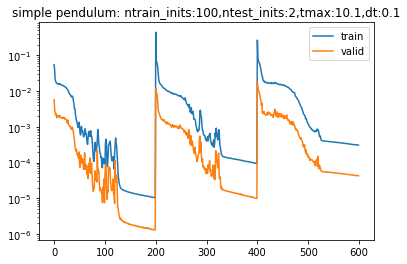

In [4]:
from model_type_II import HNN as HNN3
model_ft = HNN3(2, 200, 1, srate)
params = list(model_ft.parameters())
optimizer_ft = torch.optim.Adam(params, 1e-2)
lr_sched = torch.optim.lr_scheduler.StepLR(optimizer_ft,250,gamma=0.1)
trained_model3 = train_model(model_ft, optimizer_ft,lr_sched, num_epochs=200, energy_term=False,integrator_embedded=True, reg_grad=False)

# torch.save(trained_model,'HNN_painleve')

In [9]:
"""
Author: ***
Code to produce the results obtained in VIGN: Variational Integrator Graph Networks

"""

# %%


inference_model = trained_model3

n_test_traj = 1
num_nodes = 2
T_max_t = 10.1
dt = 0.1
srate = 0.1

bs = int(T_max_t//dt)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

# train_data = pend_chaos(num_trajectories, T_max, dt, srate, 0)#pendulum(num_trajectories, T_max, dt, srate, noise_std=0, seed=3)
valid_data = pend_chaos(n_test_traj, T_max_t, dt, srate, 1)#pendulum(n_test_traj, T_max_t, dt, srate, noise_std=0, seed=5)

# tnow, tnext, tenergy, tdx,tevals = nownext(train_data, num_trajectories, T_max, dt, srate)
vnow, vnext, venergy, vdx,vevals = nownext(valid_data, n_test_traj, T_max_t, dt, srate)


# traindat = pendpixdata(tnow, tnext, tenergy, tdx,tevals)
# train_dataloader = DataLoader(traindat, batch_size=200, num_workers=2, shuffle=True)
valdat = pendpixdata(vnow, vnext, venergy, vdx,vevals)
val_dataloader = DataLoader(valdat, batch_size=bs, num_workers=2, shuffle=False)

data_dict = { 'valid': val_dataloader}
running_losses = 0.
loss_collater = {'train': [], 'valid': []}


phase = 'valid'

main_pred =[]
for batch_i, (q, q_next, energy_, qdx,tevals) in enumerate(data_dict['valid']):
    if phase == 'train':
        optimizer.zero_grad()
    q, q_next, qdx = q.float(), q_next.float(), qdx.float()
    q.to(device)
    q_next.to(device)
    energy_.to(device)
    qdx.to(device)
    tevals = tevals.float()
    tevals.to(device)
    loss = 0
    q.requires_grad = True
    tevals.requires_grad = True

    qinit = q[0].reshape(1, -1)

    preds = []
    for i in range(len(q_next)):
        next_step_pred = inference_model.next_step(qinit,tevals[i])
        preds.append(next_step_pred)
        qinit = next_step_pred

    preds = torch.cat(preds).detach().numpy()
    q_next = q_next.detach().numpy()

    main_pred.append((preds,q_next))
    

cpu


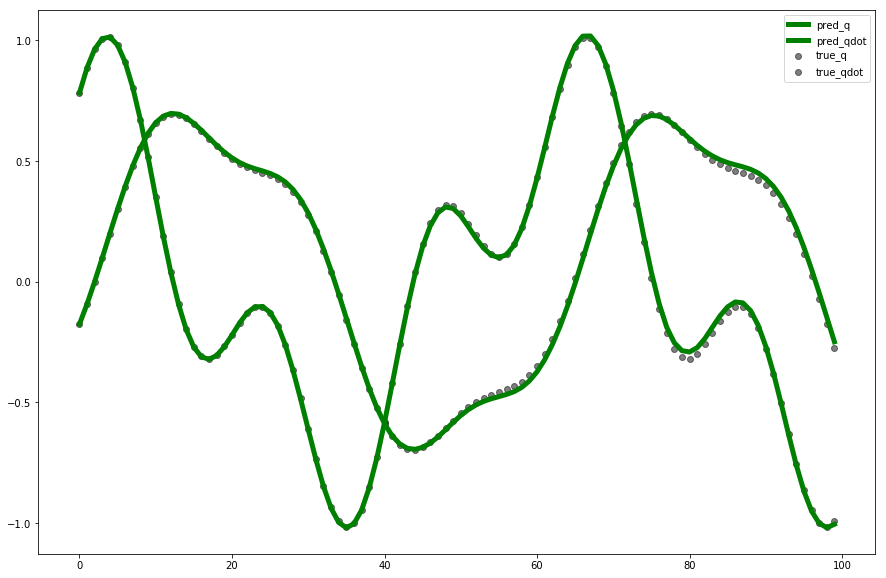

In [6]:
for j in range(n_test_traj):
    preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

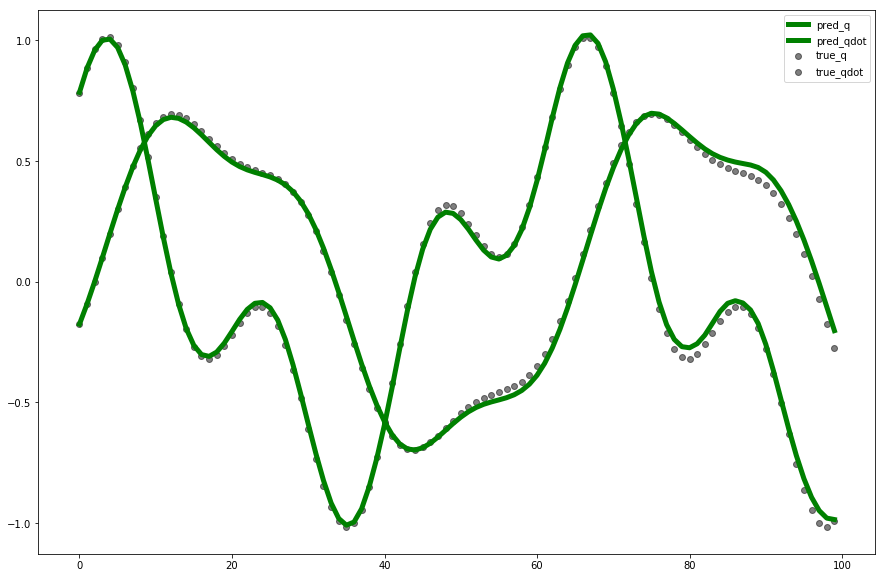

In [8]:
for j in range(n_test_traj):
    preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

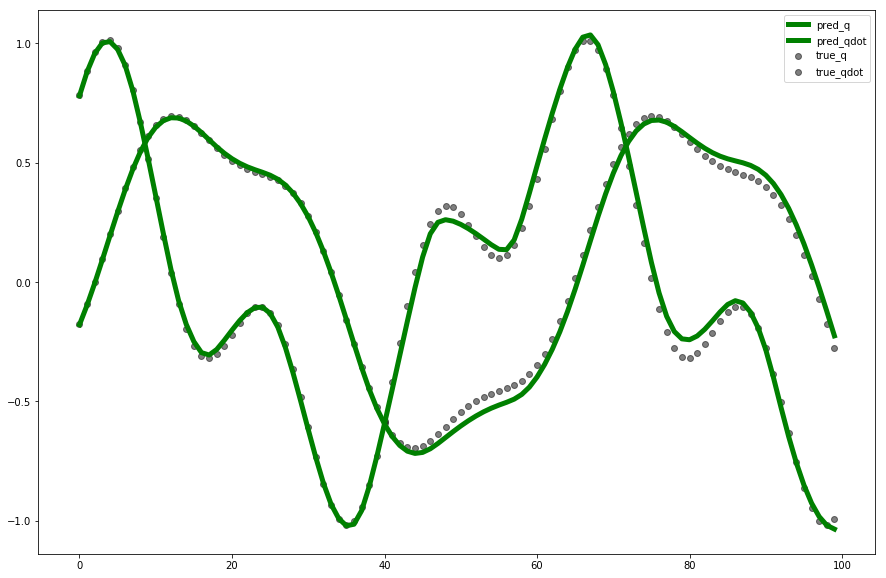

In [10]:
for j in range(n_test_traj):
#     preds,q_next = main_pred[j]
    plt.figure(figsize=(15,10))
    plt.scatter(range(len(q_next)),q_next[:,0],c='black',label='true_q',alpha=.5)
    plt.scatter(range(len(q_next)),q_next[:,1],c='black',label='true_qdot',alpha=.5)
    plt.plot(preds[:,0],c='green',label='pred_q',linewidth=5.0)
    plt.plot(preds[:,1],c='green',label='pred_qdot',linewidth=5.0)
    plt.legend(loc='best')

## evidence suggests that learning the force separately leads to better inference despite comparable state loss.. basically the new regularization only helps a little

In [8]:
torch.tensor(tnow).split(1,1)

(tensor([[0.2323],
         [0.2426],
         [0.2529],
         ...,
         [0.6765],
         [0.6699],
         [0.6633]], dtype=torch.float64), tensor([[ 1.0241],
         [ 1.0317],
         [ 1.0392],
         ...,
         [-0.6529],
         [-0.6588],
         [-0.6644]], dtype=torch.float64))

In [9]:
tnow

array([[ 0.2323083 ,  1.02410753],
       [ 0.24258759,  1.0317316 ],
       [ 0.25294256,  1.03924355],
       ...,
       [ 0.6764828 , -0.65291534],
       [ 0.66992368, -0.6588496 ],
       [ 0.66330703, -0.66441935]])